# Experiment 3.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import ast
import json

2024-05-07 13:15:20.338704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 13:15:20.338828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 13:15:20.486628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Meta dataset preprocessing

In [2]:
meta_csv_file_path = '/kaggle/input/meta-pet-supplies-csv/meta_pet_supplies_csv.csv'
df_meta = pd.read_csv(meta_csv_file_path)

print("Number of rows in the dataset:", df_meta.shape[0])
print("Number of columns in the dataset:", df_meta.shape[1])

Number of rows in the dataset: 205999
Number of columns in the dataset: 19


In [3]:
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"['Pet Supplies', 'Dogs', 'Health Supplies', 'H...",NaN,['Dr. Rexy hemp oil has powerful anti-inflamma...,NaN,DR.REXY Hemp Oil for Dogs and Cats - 100% Orga...,[],NaN,DR.REXY,['Made strictly with organic derived ingredien...,"['>#93,463 in Grocery &amp; Gourmet Food (See ...",[],Amazon Home,NaN,NaN,$19.90,061539972X,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
1,"['Pet Supplies', 'Dogs']",NaN,['Know exactly what your dog is eating with 10...,NaN,Pet Qwerks Treat Cookbook with Cutters,[],NaN,Pet Qwerks,"['Recipe book', 'Cookie cutters', 'Indoor/outd...","190,234 in Pet Supplies (","['B075DYQ1PH', '1604334657', '1604336919', '16...",Pet Supplies,NaN,NaN,$7.86,0615553605,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
2,"['Pet Supplies', 'Dogs', 'Food', 'Dry']",NaN,"['', '', '', '']",NaN,The Best of 101 Dog Tricks,"['0760339740', '1592533256', '1592535305', '15...",NaN,NaN,[],"76,847 in Movies &amp; TV (","['1592533256', '0760339740', '1592537308', '15...",Movies &amp; TV,NaN,NaN,NaN,0760339597,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
3,[],NaN,"['', 'The venomous but beautiful scorpionfishe...",NaN,Lionfishes and Other Scorpionfishes: The Compl...,"['1911142186', '1514291983']",NaN,Tfh/Nylabone,['Used Book in Good Condition'],"435,039 in Pet Supplies (",[],Pet Supplies,NaN,NaN,$24.99,0793816793,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
4,"['Pet Supplies', 'Top Selection from AmazonPets']",NaN,['Volume 1: 96 Words &amp; Phrases! This is th...,NaN,Pet Media Feathered Phonics The Easy Way To Te...,"['B0002FP328', 'B0002FP32S', 'B0002FP32I', 'B0...",NaN,Pet Media,['Award-winning audio CD teaches parrots how t...,"52,435 in Pet Supplies (","['B0002FP328', 'B00CAMARXG', 'B0002FP32S', 'B0...",Pet Supplies,NaN,NaN,$6.97,0972585419,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN


#### Drop duplicates

In [4]:
print('Number of products/rows in meta dataset:', df_meta.shape[0])
print('Number of unique products in meta dataset:', len(df_meta['asin'].unique()))

duplicate_rows = df_meta[df_meta.duplicated()]
print('Number of duplicated rows:', len(duplicate_rows))

df_meta = df_meta.drop_duplicates()
print('Number of products/rows in meta dataset after dropping duplicated rows:', df_meta.shape[0])

Number of products/rows in meta dataset: 205999
Number of unique products in meta dataset: 198265
Number of duplicated rows: 7734
Number of products/rows in meta dataset after dropping duplicated rows: 198265


#### Creating new column with the third category from the list of categories

In [5]:
def get_category(category_str):
    category_list = ast.literal_eval(category_str)
    if len(category_list) == 0: 
        return None
    if len(category_list) < 3:
        return category_list[1]
    return category_list[2]

df_meta['selected_category'] = df_meta['category'].apply(get_category)

#### Creating new column with the second category from the list of categories

In [6]:
"""
def get_category(category_str):
    category_list = ast.literal_eval(category_str)
    if len(category_list) == 0: 
        return None
    if len(category_list) < 2:
        return category_list[0]
    return category_list[1]

df_meta['selected_category'] = df_meta['category'].apply(get_category)
"""

"\ndef get_category(category_str):\n    category_list = ast.literal_eval(category_str)\n    if len(category_list) == 0: \n        return None\n    if len(category_list) < 2:\n        return category_list[0]\n    return category_list[1]\n\ndf_meta['selected_category'] = df_meta['category'].apply(get_category)\n"

In [7]:
df_meta['selected_category']

0                       Health Supplies
1                                  Dogs
2                                  Food
3                                  None
4         Top Selection from AmazonPets
                      ...              
205994     Collars, Harnesses & Leashes
205995       Carriers & Travel Products
205996            Apparel & Accessories
205997     Collars, Harnesses & Leashes
205998     Collars, Harnesses & Leashes
Name: selected_category, Length: 198265, dtype: object

In [8]:
print('Number of unique selected categories:', df_meta['selected_category'].nunique())

Number of unique selected categories: 221


#### Some records now contain None value in the selected_category, because some of the lists in the category column are empty, we will remove them

In [9]:
print('Number of products/rows in meta dataset:', df_meta.shape[0])
none_count = df_meta['selected_category'].isna().sum()
print("Number of None values in selected_category column:", none_count)

df_meta = df_meta[df_meta['selected_category'].notna()]

print("Number of None values in selected_category column after dropping rows with None values:", df_meta['selected_category'].isna().sum())
print('Number of products/rows in meta dataset after dropping rows with None values:', df_meta.shape[0])

Number of products/rows in meta dataset: 198265
Number of None values in selected_category column: 16097
Number of None values in selected_category column after dropping rows with None values: 0
Number of products/rows in meta dataset after dropping rows with None values: 182168


#### Checking which categories we have selected

In [10]:
unique_selected_category_values = df_meta['selected_category'].unique()
print(unique_selected_category_values)

['Health Supplies' 'Dogs' 'Food' 'Top Selection from AmazonPets'
 'Grooming' 'Aquarium Dcor' 'Collars, Harnesses & Leashes' 'Memorials'
 'Aquarium Pumps &amp; Filters' 'Apparel &amp; Accessories'
 'Feeding &amp; Watering Supplies' 'Treats'
 'Collars, Harnesses &amp; Leashes' 'Top Dog Supplies'
 'Training &amp; Behavior Aids' 'Aquarium Lights' 'Aquarium Substrate'
 'Aquarium Heaters' 'Flea &amp; Tick Control' 'Doors, Gates &amp; Ramps'
 'Toys' 'Doors, Gates & Ramps' 'Crates, Houses & Pens'
 'Crates, Houses &amp; Pens' 'Cages &amp; Accessories'
 'Flea & Tick Control' 'Beds & Furniture' 'Cages & Accessories'
 'Carriers &amp; Travel Products' 'Pest Control'
 'Training & Behavior Aids' 'Carriers & Travel Products'
 'Farrier Supplies' 'Stable Supplies' 'Feeding & Watering Supplies'
 'Aquariums & Fish Bowls' 'Litter &amp; Housebreaking'
 'Litter & Housebreaking' 'Pet Supplies' 'Apparel & Accessories'
 'Pet Content - Dog Main' 'Aquarium Water Treatments'
 'Beds &amp; Furniture' 'Grooming & Bat

#### Some of the selected categories have disturbed format - contain '\&amp;' instead of '&', so they are duplicated

#### For example: 
- Fish \&amp; Aquatic Pets - Fish & Aquatic Pets
- Cat Food \&amp; Supplies - Cat Food & Supplies

#### We will replace '\&amp;' with '&'

In [11]:
df_meta['selected_category'] = df_meta['selected_category'].str.replace('&amp;', '&', regex=False)
print('Number of unique selected categories after replacing &amp; with &:', len(df_meta['selected_category'].unique()))

Number of unique selected categories after replacing &amp; with &: 192


In [12]:
df_meta_selected = df_meta[['asin', 'selected_category']].copy()
df_meta_selected

,asin,selected_category
0,061539972X,Health Supplies
1,0615553605,Dogs
2,0760339597,Food
4,0972585419,Top Selection from AmazonPets
5,0975412868,Grooming
...,...,...
205994,B01HJ9ULQW,"Collars, Harnesses & Leashes"
205995,B01HJ9OZZA,Carriers & Travel Products
205996,B01HJABKBQ,Apparel & Accessories
205997,B01HJCJ8KO,"Collars, Harnesses & Leashes"


---------

## All users who had at least 3 purchases

In [13]:
with open('/kaggle/input/users-sequences-non-encoded/users_sequences_non_encoded.json', 'r') as file:
    users_sequences = json.load(file)

len(users_sequences)

601263

#### Filtering sequences in which at least min_num_of_purchases of products were purchased, i.e. users who purchased at least min_num_of_purchases of products

In [14]:
filtered_users_sequences = {}
min_num_of_purchases = 6

for key, value in users_sequences.items():
    if len(value) >= min_num_of_purchases:
        filtered_users_sequences[key] = value
        
len(filtered_users_sequences)

179703

#### Creating sequences of length sequence_length

In [15]:
sequence_length = 5
reviewer_ids = []
product_ids = []
purchased_before = [[] for _ in range(sequence_length)]

for reviewer_id, sequence in filtered_users_sequences.items():
    if len(sequence) >= sequence_length + 1:
        for i in range(len(sequence) - sequence_length):
            reviewer_ids.append(reviewer_id)
            for j in range(sequence_length):
                purchased_before[j].append(sequence[i + j])
            product_ids.append(sequence[i + sequence_length])

columns = {'reviewerID': reviewer_ids, 'productID': product_ids}
for idx in range(sequence_length):
    columns[f'purchased_before_{idx + 1}'] = purchased_before[idx]

df_users_seq = pd.DataFrame(columns)
df_users_seq

,reviewerID,productID,purchased_before_1,purchased_before_2,purchased_before_3,purchased_before_4,purchased_before_5
0,AKDVSL6YYSZ4O,B00CD0H1ZC,B0002DK26C,B000KV7ZGQ,B000YIWVA0,B000YIWVA0,B005B3LB2C
1,A2H945ZA73H7KP,B008EFHCGI,B007PJXGU0,B003NNVEUG,B001CCLDYM,B00BW63MV0,B000OUY5L6
2,A2E1IJGY51Q01J,B007C8VKXO,B003MC4DW4,B0062H5ZZ0,B000A09C4K,B0015DEMZU,B0015DEMZU
3,A17C450GVMF14F,B0018CJZ32,B014DAHV9U,B00OL96JKQ,B0007A0AQW,B0113WAUGW,B0195QTEOM
4,A2W9S2CXYV9P1B,B00CTI78F6,B0035H7GHA,B007PO2UMA,B007PO39UW,B007PO3AEC,B00AOJM6MM
...,...,...,...,...,...,...,...
984875,A1DCAZA20LD67U,B0186R3OUG,B005KSPVQ0,B00VU5QW42,B00HQME6Y6,B004LOABSC,B00JFT6JE8
984876,A1DCAZA20LD67U,B000633S4G,B00VU5QW42,B00HQME6Y6,B004LOABSC,B00JFT6JE8,B0186R3OUG
984877,A28IODJFRRZAZN,B000Y8CBTG,B000FHQKCU,B0002FP1W0,B00ROZAL0I,B00ROZAL1C,B00198SSMO
984878,A28IODJFRRZAZN,B0180A1EXI,B0002FP1W0,B00ROZAL0I,B00ROZAL1C,B00198SSMO,B000Y8CBTG


--------

### Creating an encoding dictionary, initially only from product categories in which are products from targets

In [16]:
unique_product_ids = df_users_seq['productID'].unique()
print('Number of unique products in targets:', len(unique_product_ids))

filtered_df_for_targets = df_meta_selected[df_meta_selected['asin'].isin(unique_product_ids)].copy()
filtered_df_for_targets

Number of unique products in targets: 90623


,asin,selected_category
4,0972585419,Top Selection from AmazonPets
18,1300451122,Feeding & Watering Supplies
20,1300451459,Treats
21,1300451238,Health Supplies
22,1300451467,Feeding & Watering Supplies
...,...,...
205990,B01HJ8UMTE,Apparel & Accessories
205991,B01HJ8UMTO,Apparel & Accessories
205992,B01HJ8UMSK,Apparel & Accessories
205996,B01HJABKBQ,Apparel & Accessories


In [17]:
unique_selected_categories_targets = filtered_df_for_targets['selected_category'].unique()
print("Product categories in which products from targets are:", unique_selected_categories_targets)
print("Number of categories in which these products are:", len(unique_selected_categories_targets))

Product categories in which products from targets are: ['Top Selection from AmazonPets' 'Feeding & Watering Supplies' 'Treats'
 'Health Supplies' 'Food' 'Dogs' 'Training & Behavior Aids' 'Memorials'
 'Collars, Harnesses & Leashes' 'Doors, Gates & Ramps' 'Grooming' 'Toys'
 'Cages & Accessories' 'Crates, Houses & Pens' 'Flea & Tick Control'
 'Aquarium Pumps & Filters' 'Aquarium Heaters' 'Aquarium Dcor'
 'Top Dog Supplies' 'Carriers & Travel Products' 'Farrier Supplies'
 'Litter & Housebreaking' 'Aquariums & Fish Bowls' 'Beds & Furniture'
 'Pet Content - Dog Main' 'Stable Supplies' 'Aquarium Water Treatments'
 'Pets' 'Fencing & Containment' 'Birds' 'Aquarium Thermometers'
 'Aquarium Test Kits' 'Pet Proofing' 'Aquarium Substrate'
 'All Recurring Delivery Products' 'Apparel & Accessories'
 'Cat Doors, Steps, Nets & Pens' 'Potty Training' 'Automatic Feeders'
 'Aquarium Cleaners' 'Aquarium Hoods' 'Habitat Lighting'
 'Terrarium Heat Lamps & Mats' 'Reptile Houses'
 'Aquatic Supplies: Recurring 

#### Creating an encoding dictionary

In [18]:
encoding = {}
for i, category in enumerate(unique_selected_categories_targets):
    encoding[category] = i

encoding

{'Top Selection from AmazonPets': 0,
 'Feeding & Watering Supplies': 1,
 'Treats': 2,
 'Health Supplies': 3,
 'Food': 4,
 'Dogs': 5,
 'Training & Behavior Aids': 6,
 'Memorials': 7,
 'Collars, Harnesses & Leashes': 8,
 'Doors, Gates & Ramps': 9,
 'Grooming': 10,
 'Toys': 11,
 'Cages & Accessories': 12,
 'Crates, Houses & Pens': 13,
 'Flea & Tick Control': 14,
 'Aquarium Pumps & Filters': 15,
 'Aquarium Heaters': 16,
 'Aquarium Dcor': 17,
 'Top Dog Supplies': 18,
 'Carriers & Travel Products': 19,
 'Farrier Supplies': 20,
 'Litter & Housebreaking': 21,
 'Aquariums & Fish Bowls': 22,
 'Beds & Furniture': 23,
 'Pet Content - Dog Main': 24,
 'Stable Supplies': 25,
 'Aquarium Water Treatments': 26,
 'Pets': 27,
 'Fencing & Containment': 28,
 'Birds': 29,
 'Aquarium Thermometers': 30,
 'Aquarium Test Kits': 31,
 'Pet Proofing': 32,
 'Aquarium Substrate': 33,
 'All Recurring Delivery Products': 34,
 'Apparel & Accessories': 35,
 'Cat Doors, Steps, Nets & Pens': 36,
 'Potty Training': 37,
 'Au

#### Completing the encoding dictionary with all categories

In [19]:
unique_selected_categories_all = df_meta_selected['selected_category'].unique()
i = len(encoding)

for category in unique_selected_categories_all:
    if category not in encoding:
        encoding[category] = i
        i += 1
        
print("Number of encoded categories in encoding dictionary:", len(encoding))
encoding

Number of encoded categories in encoding dictionary: 192


{'Top Selection from AmazonPets': 0,
 'Feeding & Watering Supplies': 1,
 'Treats': 2,
 'Health Supplies': 3,
 'Food': 4,
 'Dogs': 5,
 'Training & Behavior Aids': 6,
 'Memorials': 7,
 'Collars, Harnesses & Leashes': 8,
 'Doors, Gates & Ramps': 9,
 'Grooming': 10,
 'Toys': 11,
 'Cages & Accessories': 12,
 'Crates, Houses & Pens': 13,
 'Flea & Tick Control': 14,
 'Aquarium Pumps & Filters': 15,
 'Aquarium Heaters': 16,
 'Aquarium Dcor': 17,
 'Top Dog Supplies': 18,
 'Carriers & Travel Products': 19,
 'Farrier Supplies': 20,
 'Litter & Housebreaking': 21,
 'Aquariums & Fish Bowls': 22,
 'Beds & Furniture': 23,
 'Pet Content - Dog Main': 24,
 'Stable Supplies': 25,
 'Aquarium Water Treatments': 26,
 'Pets': 27,
 'Fencing & Containment': 28,
 'Birds': 29,
 'Aquarium Thermometers': 30,
 'Aquarium Test Kits': 31,
 'Pet Proofing': 32,
 'Aquarium Substrate': 33,
 'All Recurring Delivery Products': 34,
 'Apparel & Accessories': 35,
 'Cat Doors, Steps, Nets & Pens': 36,
 'Potty Training': 37,
 'Au

#### Encoding text categories to numeric values so we will have a numeric category value for each product

In [20]:
df_meta_selected_encoded = df_meta_selected.copy()
df_meta_selected_encoded['selected_category'] = df_meta_selected_encoded['selected_category'].map(encoding)

### Encoding product IDs into numeric product categories

#### First, selecting all unique product IDs from sequences and targets

In [21]:
unique_productID = df_users_seq['productID'].unique()
unique_purchased_before = [df_users_seq[f'purchased_before_{i+1}'].unique() for i in range(sequence_length)]

merged = np.concatenate([unique_productID] + unique_purchased_before)

unique_merged = np.unique(merged)
print("Number of unique products in sequences and targets:", len(unique_merged))

Number of unique products in sequences and targets: 115184


#### Selecting from all products which are in the meta dataset, only those which are in sequences and targets

In [22]:
filtered_df = df_meta_selected_encoded[df_meta_selected_encoded['asin'].isin(unique_merged)].copy()
filtered_df.shape[0]

115184

#### Number of unique categories in which users have purchased products / Number of categories in which are products from sequences and targets

In [23]:
unique_categories_count = filtered_df['selected_category'].nunique()
print("Number of categories which contain products purchased by all users:", unique_categories_count)

Number of categories which contain products purchased by all users: 180


#### Creating encoding dictionary which maps product IDs into numeric product categories

In [24]:
encoding_productID_to_category = filtered_df.set_index('asin')['selected_category'].to_dict()
print("Number of encoded products:", len(encoding_productID_to_category))

Number of encoded products: 115184


-------

### Creating encoded sequences and targets

In [25]:
df_users_seq_encoded = df_users_seq.copy()

df_users_seq_encoded['productID'] = df_users_seq_encoded['productID'].map(encoding_productID_to_category)
for i in range(1, sequence_length + 1):
    col_name = f'purchased_before_{i}'
    df_users_seq_encoded[col_name] = df_users_seq_encoded[col_name].map(encoding_productID_to_category)

df_users_seq_encoded

,reviewerID,productID,purchased_before_1,purchased_before_2,purchased_before_3,purchased_before_4,purchased_before_5
0,AKDVSL6YYSZ4O,10,11,11,10,10,11
1,A2H945ZA73H7KP,2,2,2,10,4,3
2,A2E1IJGY51Q01J,6,3,17,6,11,11
3,A17C450GVMF14F,21,65,91,2,6,21
4,A2W9S2CXYV9P1B,50,12,11,12,12,1
...,...,...,...,...,...,...,...
984875,A1DCAZA20LD67U,2,4,4,11,2,4
984876,A1DCAZA20LD67U,4,4,11,2,4,2
984877,A28IODJFRRZAZN,35,11,11,2,2,3
984878,A28IODJFRRZAZN,3,11,2,2,3,35


In [26]:
num_users = df_users_seq_encoded['reviewerID'].nunique()
print("Number of users:", num_users)

Number of users: 179703


#### Dropping duplicated sequences and targets

In [27]:
purchased_before_columns = [f'purchased_before_{i + 1}' for i in range(sequence_length)] + ['productID']
num_duplicates = df_users_seq_encoded.duplicated(subset=purchased_before_columns).sum()
df_users_seq_encoded_unique = df_users_seq_encoded.drop_duplicates(subset=purchased_before_columns)
print("Number of records (sequences and targets):", df_users_seq_encoded.shape[0])
print("Number of duplicates in these records:", num_duplicates)
print("Number of records after dropping duplicates:", df_users_seq_encoded_unique.shape[0])

Number of records (sequences and targets): 984880
Number of duplicates in these records: 308039
Number of records after dropping duplicates: 676841


#### Number of samples per category

In [28]:
#pd.set_option('display.max_rows', None)

In [29]:
frequency = df_users_seq_encoded_unique['productID'].value_counts()

frequency_df = pd.DataFrame(frequency.reset_index())
frequency_df.columns = ['category', 'numberOfTargetProductsInCategory']
frequency_df

,category,numberOfTargetProductsInCategory
0,11,72292
1,4,66305
2,2,62744
3,8,57474
4,3,48547
...,...,...
167,115,1
168,125,1
169,169,1
170,142,1


In [30]:
#pd.set_option('display.max_rows', 10)

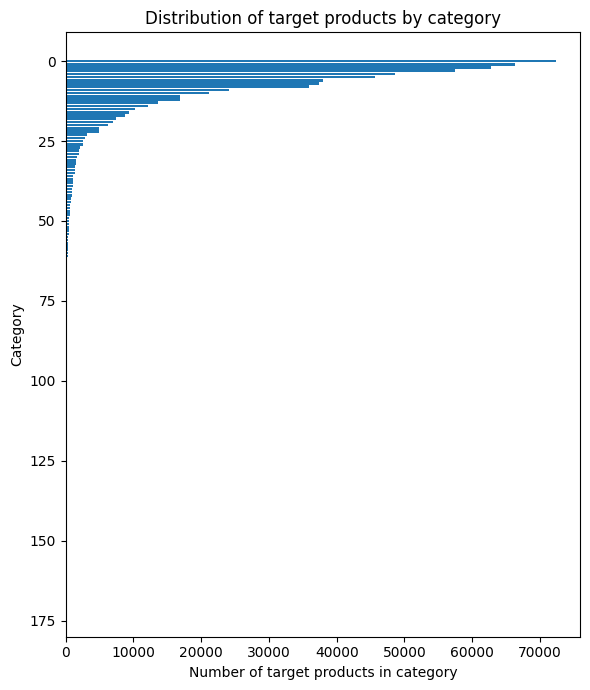

In [31]:
x = frequency_df['numberOfTargetProductsInCategory']
y = frequency_df.index

plt.figure(figsize=(6, 7))
plt.barh(y, x)
plt.gca().invert_yaxis()
plt.ylabel('Category')
plt.xlabel('Number of target products in category')
plt.title('Distribution of target products by category')
plt.tight_layout()
plt.show() 

In [32]:
sequences = df_users_seq_encoded_unique[purchased_before_columns].values
targets = df_users_seq_encoded_unique['productID'].values

print("Sequences:")
print(sequences[:10])
print("\nTargets:")
print(targets[:10])

Sequences:
[[11 11 10 10 11 10]
 [ 2  2 10  4  3  2]
 [ 3 17  6 11 11  6]
 [65 91  2  6 21 21]
 [12 11 12 12  1 50]
 [11 35  2 35  1 11]
 [ 3  3  3  4  4  2]
 [10 23 11 19 11  6]
 [21 21 21 21 21 21]
 [35 35 13 35 35 35]]

Targets:
[10  2  6 21 50 11  2  6 21 35]


----------

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [33]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(np.ceil(train_size * n))
        n_test = int(np.floor(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_val < min_size:
            n_val = min_size
        if n_test < min_size:
            n_test = min_size

        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_val >= n_test:
                n_val -= min(excess, (n_val - min_size))
            else:
                n_test -= min(excess, (n_test - min_size))
            excess = (n_train + n_test + n_val) - n
            if excess > 0 and n_train > min_size:
                n_train -= excess
        
        n_train = max(n_train, min_size)
        n_test = max(n_test, 0)
        n_val = max(n_val, 0)

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique categories) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 541500
Number of validation sequences: 67708
Number of test sequences: 67633

Number of train targets: 541500
Number of validation targets: 67708
Number of test targets: 67633

Number of classes (unique categories) in the train targets: 172
Number of classes in the validation targets: 164
Number of classes in the test targets: 151


-------

### Defining metric weighted F1-score

In [35]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=len(unique_selected_categories_targets))
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=len(unique_selected_categories_targets))

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### Applying logarithmic scale to moderate high weights

In [36]:
def custom_class_weights(y_train):
    class_counts = np.bincount(y_train)
    total_instances = len(y_train)
    weights = total_instances / (len(class_counts) * class_counts)
    return np.log1p(weights)

class_weight_dict = {i: weight for i, weight in enumerate(custom_class_weights(y_train))}

-----

# Training and evaluating models

# LSTM

In [37]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_lstm.add(LSTM(4, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(4, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score]
)

In [38]:
history_model_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  41/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.0169 - f1_score: 0.0119 - loss: 1.2532         

I0000 00:00:1715087787.388904     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8461/8461 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.2684 - f1_score: 0.2589 - loss: 0.8106 - val_accuracy: 0.9751 - val_f1_score: 0.9756 - val_loss: 0.7386
Epoch 2/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.6033 - f1_score: 0.6074 - loss: 0.5084 - val_accuracy: 0.9327 - val_f1_score: 0.9342 - val_loss: 0.4653
Epoch 3/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.6743 - f1_score: 0.6765 - loss: 0.4454 - val_accuracy: 0.9354 - val_f1_score: 0.9386 - val_loss: 0.3060
Epoch 4/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7107 - f1_score: 0.7121 - loss: 0.4086 - val_accuracy: 0.9420 - val_f1_score: 0.9516 - val_loss: 0.2546
Epoch 5/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7326 - f1_score: 0.7343 - loss: 0.3770 - val_accuracy: 0.8667 - val_f1_score: 0.8688 - val_loss: 0.6479
Epoch 6/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7427 - f1_score: 0.7436 - loss: 0.3570 - val_accuracy: 0.9190 - val_f1_score:

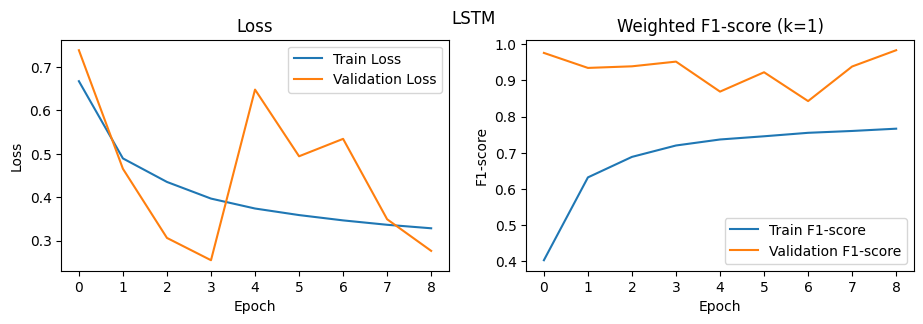

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('Weighted F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('LSTM')
plt.show()

In [40]:
test_loss_model_lstm, test_accuracy_model_lstm, test_f1_score_model_lstm = model_lstm.evaluate(X_test, y_test)

probabilities_model_lstm = model_lstm.predict(X_test)
y_pred_model_lstm = np.argmax(probabilities_model_lstm, axis=1)
report_dict_model_lstm = classification_report(y_test, y_pred_model_lstm, output_dict=True)

weighted_avg_model_lstm = report_dict_model_lstm['weighted avg']
test_weighted_avg_precision_model_lstm = round(weighted_avg_model_lstm['precision'], 4)
test_weighted_avg_recall_model_lstm = round(weighted_avg_model_lstm['recall'], 4)
test_weighted_avg_f1_model_lstm = round(weighted_avg_model_lstm['f1-score'], 4)

macro_avg_model_lstm = report_dict_model_lstm['macro avg']
test_macro_avg_precision_model_lstm = round(macro_avg_model_lstm['precision'], 4)
test_macro_avg_recall_model_lstm = round(macro_avg_model_lstm['recall'], 4)
test_macro_avg_f1_model_lstm = round(macro_avg_model_lstm['f1-score'], 4)

test_loss_model_lstm = round(test_loss_model_lstm, 4)
test_accuracy_model_lstm = round(report_dict_model_lstm['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_lstm)
print("Test weighted avg precision:", test_weighted_avg_precision_model_lstm)
print("Test weighted avg recall:", test_weighted_avg_recall_model_lstm)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_lstm)
print("Test macro avg precision:", test_macro_avg_precision_model_lstm)
print("Test macro avg recall:", test_macro_avg_recall_model_lstm)
print("-----------------------------------------")
print("Test loss:", test_loss_model_lstm)
print("Test accuracy:", test_accuracy_model_lstm)
print("-----------------------------------------")

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9993 - f1_score: 0.9995 - loss: 0.2042
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
-----------------------------------------
Test weighted avg f1-score: 0.9782
Test weighted avg precision: 0.9763
Test weighted avg recall: 0.9822
-----------------------------------------
Test macro avg f1-score: 0.4614
Test macro avg precision: 0.4565
Test macro avg recall: 0.478
-----------------------------------------
Test loss: 0.2729
Test accuracy: 0.9822
-----------------------------------------


---------

# Bidirectional-LSTM

In [41]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_bi_lstm.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(8, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', f1_score]
)

In [42]:
history_model_bi_lstm = model_bi_lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - accuracy: 0.7015 - f1_score: 0.7012 - loss: 0.4500 - val_accuracy: 0.9984 - val_f1_score: 0.9984 - val_loss: 0.0125
Epoch 2/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.9760 - f1_score: 0.9795 - loss: 0.0720 - val_accuracy: 0.9988 - val_f1_score: 0.9988 - val_loss: 0.0079
Epoch 3/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.9818 - f1_score: 0.9846 - loss: 0.0544 - val_accuracy: 0.9993 - val_f1_score: 0.9993 - val_loss: 0.0049
Epoch 4/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.9850 - f1_score: 0.9874 - loss: 0.0424 - val_accuracy: 0.9994 - val_f1_score: 0.9993 - val_loss: 0.0043
Epoch 5/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.9870 - f1_score: 0.9892 - loss: 0.0400 - val_accuracy: 0.9994 - val_f1_score: 0.9993 - val_loss: 0.0038
Epoch 6/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.9875 - f1_score: 0.9897 - loss: 0.0347 - val_accuracy: 0.9994 - va

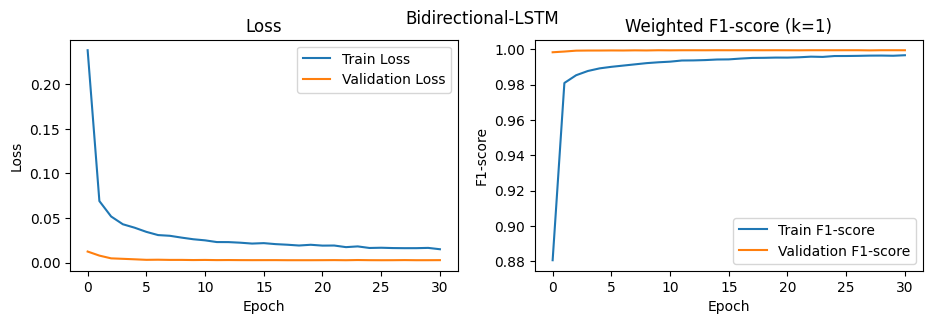

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('Weighted F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [44]:
test_loss_model_bi_lstm, test_accuracy_model_bi_lstm, test_f1_score_model_bi_lstm = model_bi_lstm.evaluate(X_test, y_test)

probabilities_model_bi_lstm = model_bi_lstm.predict(X_test)
y_pred_model_bi_lstm = np.argmax(probabilities_model_bi_lstm, axis=1)
report_dict_model_bi_lstm = classification_report(y_test, y_pred_model_bi_lstm, output_dict=True)

weighted_avg_model_bi_lstm = report_dict_model_bi_lstm['weighted avg']
test_weighted_avg_precision_model_bi_lstm = round(weighted_avg_model_bi_lstm['precision'], 4)
test_weighted_avg_recall_model_bi_lstm = round(weighted_avg_model_bi_lstm['recall'], 4)
test_weighted_avg_f1_model_bi_lstm = round(weighted_avg_model_bi_lstm['f1-score'], 4)

macro_avg_model_bi_lstm = report_dict_model_bi_lstm['macro avg']
test_macro_avg_precision_model_bi_lstm = round(macro_avg_model_bi_lstm['precision'], 4)
test_macro_avg_recall_model_bi_lstm = round(macro_avg_model_bi_lstm['recall'], 4)
test_macro_avg_f1_model_bi_lstm = round(macro_avg_model_bi_lstm['f1-score'], 4)

test_loss_model_bi_lstm = round(test_loss_model_bi_lstm, 4)
test_accuracy_model_bi_lstm = round(report_dict_model_bi_lstm['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_bi_lstm)
print("Test weighted avg precision:", test_weighted_avg_precision_model_bi_lstm)
print("Test weighted avg recall:", test_weighted_avg_recall_model_bi_lstm)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_bi_lstm)
print("Test macro avg precision:", test_macro_avg_precision_model_bi_lstm)
print("Test macro avg recall:", test_macro_avg_recall_model_bi_lstm)
print("-----------------------------------------")
print("Test loss:", test_loss_model_bi_lstm)
print("Test accuracy:", test_accuracy_model_bi_lstm)
print("-----------------------------------------")

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 8.7948e-05
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
-----------------------------------------
Test weighted avg f1-score: 0.9997
Test weighted avg precision: 0.9997
Test weighted avg recall: 0.9997
-----------------------------------------
Test macro avg f1-score: 0.8646
Test macro avg precision: 0.8624
Test macro avg recall: 0.8742
-----------------------------------------
Test loss: 0.0017
Test accuracy: 0.9997
-----------------------------------------


----------

# GRU

In [45]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_gru.add(GRU(16, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', f1_score]
)

In [46]:
history_model_gru = model_gru.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9172 - f1_score: 0.9123 - loss: 0.2540 - val_accuracy: 0.9991 - val_f1_score: 0.9991 - val_loss: 0.0063
Epoch 2/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9920 - f1_score: 0.9933 - loss: 0.0321 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - val_loss: 0.0038
Epoch 3/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9939 - f1_score: 0.9949 - loss: 0.0232 - val_accuracy: 0.9995 - val_f1_score: 0.9994 - val_loss: 0.0031
Epoch 4/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9946 - f1_score: 0.9955 - loss: 0.0204 - val_accuracy: 0.9995 - val_f1_score: 0.9995 - val_loss: 0.0027
Epoch 5/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9956 - f1_score: 0.9963 - loss: 0.0164 - val_accuracy: 0.9995 - val_f1_score: 0.9995 - val_loss: 0.0025
Epoch 6/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9959 - f1_score: 0.9966 - loss: 0.0142 - val_accuracy: 0.9995 - va

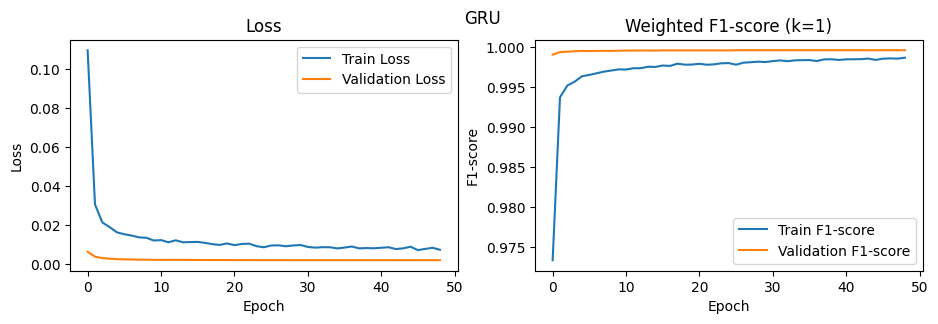

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('Weighted F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('GRU')
plt.show()

In [48]:
test_loss_model_gru, test_accuracy_model_gru, test_f1_score_model_gru = model_gru.evaluate(X_test, y_test)

probabilities_model_gru = model_gru.predict(X_test)
y_pred_model_gru = np.argmax(probabilities_model_gru, axis=1)
report_dict_model_gru = classification_report(y_test, y_pred_model_gru, output_dict=True)

weighted_avg_model_gru = report_dict_model_gru['weighted avg']
test_weighted_avg_precision_model_gru = round(weighted_avg_model_gru['precision'], 4)
test_weighted_avg_recall_model_gru = round(weighted_avg_model_gru['recall'], 4)
test_weighted_avg_f1_model_gru = round(weighted_avg_model_gru['f1-score'], 4)

macro_avg_model_gru = report_dict_model_gru['macro avg']
test_macro_avg_precision_model_gru = round(macro_avg_model_gru['precision'], 4)
test_macro_avg_recall_model_gru = round(macro_avg_model_gru['recall'], 4)
test_macro_avg_f1_model_gru = round(macro_avg_model_gru['f1-score'], 4)

test_loss_model_gru = round(test_loss_model_gru, 4)
test_accuracy_model_gru = round(report_dict_model_gru['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_gru)
print("Test weighted avg precision:", test_weighted_avg_precision_model_gru)
print("Test weighted avg recall:", test_weighted_avg_recall_model_gru)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_gru)
print("Test macro avg precision:", test_macro_avg_precision_model_gru)
print("Test macro avg recall:", test_macro_avg_recall_model_gru)
print("-----------------------------------------")
print("Test loss:", test_loss_model_gru)
print("Test accuracy:", test_accuracy_model_gru)
print("-----------------------------------------")

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.4719e-05
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
-----------------------------------------
Test weighted avg f1-score: 0.9998
Test weighted avg precision: 0.9998
Test weighted avg recall: 0.9998
-----------------------------------------
Test macro avg f1-score: 0.9149
Test macro avg precision: 0.9144
Test macro avg recall: 0.9205
-----------------------------------------
Test loss: 0.0009
Test accuracy: 0.9998
-----------------------------------------


----------

# Autoencoder

In [49]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', f1_score]
)

In [50]:
history_model_autoencoder = model_autoencoder.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.6130 - f1_score: 0.6259 - loss: 0.5673 - val_accuracy: 0.9973 - val_f1_score: 0.9973 - val_loss: 0.0188
Epoch 2/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9108 - f1_score: 0.9243 - loss: 0.1707 - val_accuracy: 0.9984 - val_f1_score: 0.9984 - val_loss: 0.0098
Epoch 3/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9332 - f1_score: 0.9443 - loss: 0.1288 - val_accuracy: 0.9990 - val_f1_score: 0.9990 - val_loss: 0.0075
Epoch 4/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9455 - f1_score: 0.9550 - loss: 0.1052 - val_accuracy: 0.9992 - val_f1_score: 0.9992 - val_loss: 0.0064
Epoch 5/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9547 - f1_score: 0.9627 - loss: 0.0860 - val_accuracy: 0.9993 - val_f1_score: 0.9993 - val_loss: 0.0055
Epoch 6/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9599 - f1_score: 0.9669 - loss: 0.0771 - val_accuracy: 0.9994 - va

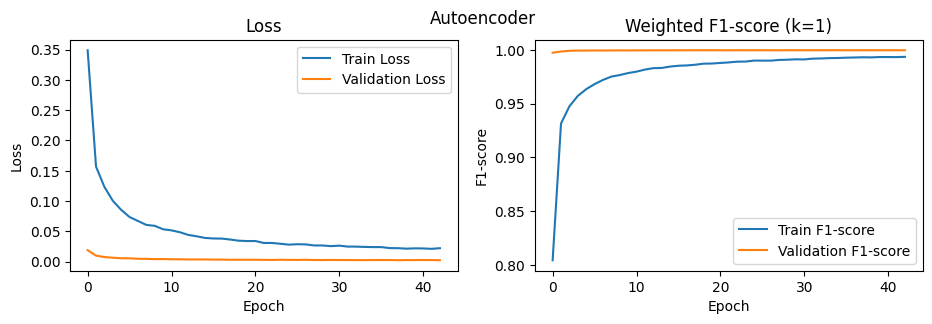

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('Weighted F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('Autoencoder')
plt.show()

In [52]:
test_loss_model_autoencoder, test_accuracy_model_autoencoder, test_f1_score_model_autoencoder = model_autoencoder.evaluate(X_test, y_test)

probabilities_model_autoencoder = model_autoencoder.predict(X_test)
y_pred_model_autoencoder = np.argmax(probabilities_model_autoencoder, axis=1)
report_dict_model_autoencoder = classification_report(y_test, y_pred_model_autoencoder, output_dict=True)

weighted_avg_model_autoencoder = report_dict_model_autoencoder['weighted avg']
test_weighted_avg_precision_model_autoencoder = round(weighted_avg_model_autoencoder['precision'], 4)
test_weighted_avg_recall_model_autoencoder = round(weighted_avg_model_autoencoder['recall'], 4)
test_weighted_avg_f1_model_autoencoder = round(weighted_avg_model_autoencoder['f1-score'], 4)

macro_avg_model_autoencoder = report_dict_model_autoencoder['macro avg']
test_macro_avg_precision_model_autoencoder = round(macro_avg_model_autoencoder['precision'], 4)
test_macro_avg_recall_model_autoencoder = round(macro_avg_model_autoencoder['recall'], 4)
test_macro_avg_f1_model_autoencoder = round(macro_avg_model_autoencoder['f1-score'], 4)

test_loss_model_autoencoder = round(test_loss_model_autoencoder, 4)
test_accuracy_model_autoencoder = round(report_dict_model_autoencoder['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_autoencoder)
print("Test weighted avg precision:", test_weighted_avg_precision_model_autoencoder)
print("Test weighted avg recall:", test_weighted_avg_recall_model_autoencoder)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_autoencoder)
print("Test macro avg precision:", test_macro_avg_precision_model_autoencoder)
print("Test macro avg recall:", test_macro_avg_recall_model_autoencoder)
print("-----------------------------------------")
print("Test loss:", test_loss_model_autoencoder)
print("Test accuracy:", test_accuracy_model_autoencoder)
print("-----------------------------------------")

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.2412e-05
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
-----------------------------------------
Test weighted avg f1-score: 0.9997
Test weighted avg precision: 0.9997
Test weighted avg recall: 0.9998
-----------------------------------------
Test macro avg f1-score: 0.8943
Test macro avg precision: 0.8891
Test macro avg recall: 0.9073
-----------------------------------------
Test loss: 0.001
Test accuracy: 0.9998
-----------------------------------------


--------

# CNN

In [53]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_cnn.add(Conv1D(8, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(8, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score]
)

In [54]:
history_model_cnn = model_cnn.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.3352 - f1_score: 0.3343 - loss: 0.7760 - val_accuracy: 0.9820 - val_f1_score: 0.9856 - val_loss: 0.3611
Epoch 2/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7473 - f1_score: 0.7629 - loss: 0.3571 - val_accuracy: 0.9946 - val_f1_score: 0.9947 - val_loss: 0.1203
Epoch 3/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8125 - f1_score: 0.8223 - loss: 0.2850 - val_accuracy: 0.9970 - val_f1_score: 0.9972 - val_loss: 0.0604
Epoch 4/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8518 - f1_score: 0.8582 - loss: 0.2456 - val_accuracy: 0.9977 - val_f1_score: 0.9977 - val_loss: 0.0364
Epoch 5/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8697 - f1_score: 0.8751 - loss: 0.2174 - val_accuracy: 0.9985 - val_f1_score: 0.9985 - val_loss: 0.0249
Epoch 6/50
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8769 - f1_score: 0.8821 - loss: 0.2101 - val_accuracy: 0.9983 - va

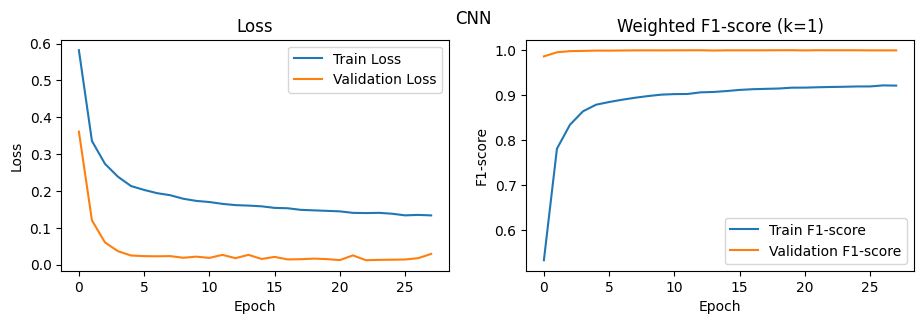

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('Weighted F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('CNN')
plt.show()

In [56]:
test_loss_model_cnn, test_accuracy_model_cnn, test_f1_score_model_cnn = model_cnn.evaluate(X_test, y_test)

probabilities_model_cnn = model_cnn.predict(X_test)
y_pred_model_cnn = np.argmax(probabilities_model_cnn, axis=1)
report_dict_model_cnn = classification_report(y_test, y_pred_model_cnn, output_dict=True)

weighted_avg_model_cnn = report_dict_model_cnn['weighted avg']
test_weighted_avg_precision_model_cnn = round(weighted_avg_model_cnn['precision'], 4)
test_weighted_avg_recall_model_cnn = round(weighted_avg_model_cnn['recall'], 4)
test_weighted_avg_f1_model_cnn = round(weighted_avg_model_cnn['f1-score'], 4)

macro_avg_model_cnn = report_dict_model_cnn['macro avg']
test_macro_avg_precision_model_cnn = round(macro_avg_model_cnn['precision'], 4)
test_macro_avg_recall_model_cnn = round(macro_avg_model_cnn['recall'], 4)
test_macro_avg_f1_model_cnn = round(macro_avg_model_cnn['f1-score'], 4)

test_loss_model_cnn = round(test_loss_model_cnn, 4)
test_accuracy_model_cnn = round(report_dict_model_cnn['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_cnn)
print("Test weighted avg precision:", test_weighted_avg_precision_model_cnn)
print("Test weighted avg recall:", test_weighted_avg_recall_model_cnn)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_cnn)
print("Test macro avg precision:", test_macro_avg_precision_model_cnn)
print("Test macro avg recall:", test_macro_avg_recall_model_cnn)
print("-----------------------------------------")
print("Test loss:", test_loss_model_cnn)
print("Test accuracy:", test_accuracy_model_cnn)
print("-----------------------------------------")

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9989 - f1_score: 0.9994 - loss: 0.0547
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
-----------------------------------------
Test weighted avg f1-score: 0.999
Test weighted avg precision: 0.9989
Test weighted avg recall: 0.9991
-----------------------------------------
Test macro avg f1-score: 0.8211
Test macro avg precision: 0.8145
Test macro avg recall: 0.8364
-----------------------------------------
Test loss: 0.0278
Test accuracy: 0.9991
-----------------------------------------
